This project was authored by Eli Sinai and Daniel Meir Karl.

In this notebook, you can test the models we have trained.


In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import joblib
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential

from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.applications import VGG19, resnet
from PIL import Image
import io
import scipy
from tensorflow.keras.models import Model, load_model

Mounted at /content/drive


# Notebook Constants

After downloading the weights, please modify the paths vars to your weights exact location

In [ ]:
binary_labels = ["NORMAL", "PNEUMONIA"]
multiclass_labels = ["BACTERIAL", "NORMAL", "VIRAL"]

IMG_SIZE = (280, 280)

BINARY_MODEL_WEIGHTS_PATH = "/content/drive/MyDrive/University/DL-Project/models/binary_model_VGG19_finetuned_final.keras"

MULTICLASS_MODEL_WEIGHTS_PATH = "/content/drive/MyDrive/University/DL-Project/models/multiclass_model_ResNet101.keras"

ANOMALY_MODEL_WEIGHTS_PATH = "/content/drive/MyDrive/University/DL-Project/models/encoder_decoder_weights_final.h5"

BINARY_KNN_PATH = "/content/drive/MyDrive/University/DL-Project/models/binary_knn_classifier.joblib"
MULTI_KNN_PATH = "/content/drive/MyDrive/University/DL-Project/models/multi_knn_classifier.joblib"

# Classifications

In [ ]:
resize_scale = keras.Sequential(
    [layers.Resizing(*IMG_SIZE), layers.Rescaling(1.0 / 255)]
)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(factor=0.05),
        layers.RandomZoom(height_factor=-0.1, width_factor=-0.1),
    ]
)

> Preprocess a byte encoded images to np.array then apply central cropping on them.

In [ ]:
def preprocess_image(image, central_crop_fraction: float) -> tf.Tensor:
  image = cv2.imdecode(np.frombuffer(image, np.uint8), cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, IMG_SIZE)
  image = tf.image.central_crop(image, central_crop_fraction)
  return image

> Classify byte encoded images with the model and plot their model predictions.

In [ ]:
def classify_images(model: keras.Model,
                    images,
                    central_crop_fraction: float,
                    labels: list[str],
                    threshold: float = 0.6):
  # converting images to numpy arrays
  images = np.array([preprocess_image(img, central_crop_fraction) for img in images])

  # get the probabilities from the model using the images
  probabilities = model.predict(images, verbose=0)

  num_cols = 3
  num_rows = (len(images) + num_cols - 1) // num_cols

  plt.figure(figsize=(3*num_cols, 3*num_rows))
  for idx, img in enumerate(images):
    p = plt.subplot(num_rows, num_cols, idx + 1)
    p.imshow(img)
    idx_max_prob = 1 if probabilities[idx, 0] >= threshold else 0
    if len(labels) > 2:
      idx_max_prob = probabilities[idx].argmax()

    p.set_title(f"prediction: {labels[idx_max_prob]}")
    p.axis("off")

  plt.show()

## Classification of healthy/sick

In [ ]:
CNR_IMG_INPUT_SHAPE = (180, 180, 3)

In [ ]:
def get_binary_model() -> keras.Model:
    base = VGG19(include_top=False, weights="imagenet", input_shape=CNR_IMG_INPUT_SHAPE)
    base.trainable = True

    model = Sequential(
        [
            layers.Input(shape=CNR_IMG_INPUT_SHAPE),
            data_augmentation,
            base,
            layers.Dropout(0.2),
            layers.GlobalAveragePooling2D(),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    start_lr = 0.0001
    learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
        start_lr, decay_steps=100000, decay_rate=0.96, staircase=True
    )
    model.compile(
        optimizer=optimizers.RMSprop(learning_rate_schedule),
        loss=losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )
    return model

In [ ]:
binary_model = get_binary_model()
binary_model.load_weights(BINARY_MODEL_WEIGHTS_PATH)

> Now you can try our binary model! run the next cell and upload images

In [ ]:
binary_uploaded_files = files.upload()

Saving NORMAL2-IM-0059-0001.jpeg to NORMAL2-IM-0059-0001.jpeg
Saving NORMAL2-IM-0073-0001.jpeg to NORMAL2-IM-0073-0001 (1).jpeg
Saving NORMAL2-IM-0079-0001.jpeg to NORMAL2-IM-0079-0001.jpeg


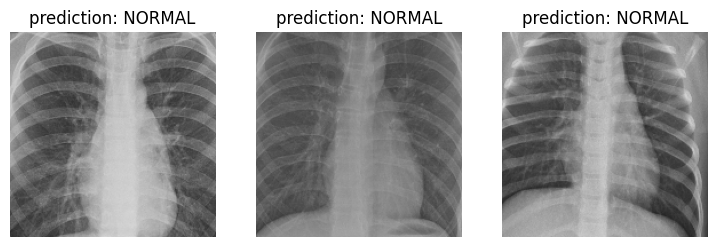

In [ ]:
binary_images = list(binary_uploaded_files.values())
classify_images(binary_model,
                binary_images,
                central_crop_fraction=0.64,
                labels=binary_labels)

## Classification of healthy/bacterial pneumonia/viral pneumonia

In [ ]:
CNR_IMG_MULTICLASS_INPUT_SHAPE=(202, 202, 3)

In [ ]:
def get_multiclass_model() -> keras.Model:
  base = resnet.ResNet101(
      include_top=False,
      weights="imagenet",
      input_shape=CNR_IMG_MULTICLASS_INPUT_SHAPE
  )
  base.trainable = False

  model = Sequential([
      layers.Input(shape=CNR_IMG_MULTICLASS_INPUT_SHAPE),
      data_augmentation,
      base,
      layers.GlobalAveragePooling2D(),
      layers.Dense(512, activation="relu"),
      layers.Dropout(0.3),
      layers.Dense(256, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dropout(0.2),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(3, activation="softmax")
  ])

  start_lr = 0.001
  learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
  start_lr, decay_steps=100000, decay_rate=0.96, staircase=True
  )
  model.compile(
      optimizer=optimizers.RMSprop(learning_rate_schedule),
      loss=losses.CategoricalCrossentropy(),
      metrics=["accuracy"],
  )
  return model

In [ ]:
multiclass_model = get_multiclass_model()
multiclass_model.load_weights(MULTICLASS_MODEL_WEIGHTS_PATH)

171446536/171446536 [==============================] - 1s 0us/step


> Now you can try our multi-class model! <br>
Run the next cell and upload images

In [ ]:
multi_uploaded_files = files.upload()

Saving person83_bacteria_407.jpeg to person83_bacteria_407.jpeg
Saving person89_bacteria_440.jpeg to person89_bacteria_440.jpeg
Saving person1667_virus_2881.jpeg to person1667_virus_2881.jpeg


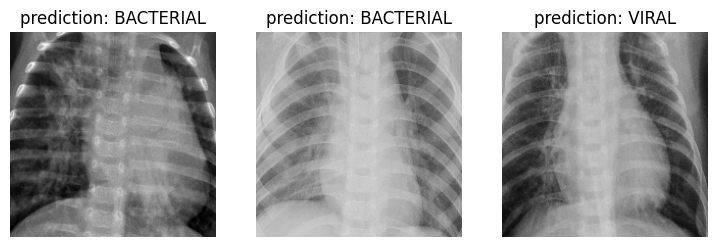

In [ ]:
multi_images = list(multi_uploaded_files.values())
classify_images(multiclass_model,
                multi_images,
                central_crop_fraction=0.72,
                labels=multiclass_labels)

## Classification via Embedding Vector & KNN
Now you can see the classification of the images you chose for binary and multiclass models, when feeding the embedding vector KNN model.

> Feed images to the model. <br>
Returns an embedding vector from it's one before the last layer.

In [ ]:
def embedding_vectors_from_model(
    model: keras.Model, images: np.ndarray
) -> np.ndarray:
    emd_model = keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    emd_vec = emd_model.predict(images, verbose=0)
    return emd_vec

> Gets a model, knn classifier object and an image np.ndarray. <br>
The function calculate the corresponding image embedding vector from the model, <br>
and returns it with the knn classifier prediction of it.

In [ ]:
def classify_new_images_emd_KNN(
    model: keras.Model, knn_classifier: KNeighborsClassifier, images: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    emd_vec = embedding_vectors_from_model(model, images)
    return emd_vec, knn_classifier.predict(emd_vec)

### Classifying with binary model & KNN

In [ ]:
binary_knn_classifier = joblib.load(BINARY_KNN_PATH)

In [ ]:
binary_knn_uploaded_files = files.upload()
binary_knn_images = list(binary_knn_uploaded_files.values())
binary_knn_images = np.array([preprocess_image(img, 0.64) for img in binary_knn_images])

Saving IM-0003-0001.jpeg to IM-0003-0001.jpeg
Saving NORMAL2-IM-0059-0001.jpeg to NORMAL2-IM-0059-0001.jpeg
Saving NORMAL2-IM-0060-0001.jpeg to NORMAL2-IM-0060-0001 (1).jpeg
Saving NORMAL2-IM-0073-0001.jpeg to NORMAL2-IM-0073-0001.jpeg
Saving NORMAL2-IM-0079-0001.jpeg to NORMAL2-IM-0079-0001.jpeg


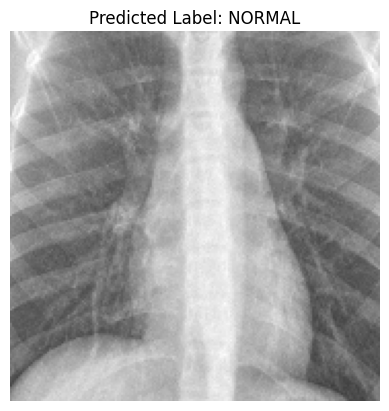

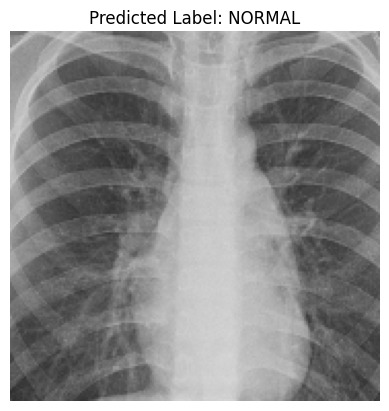

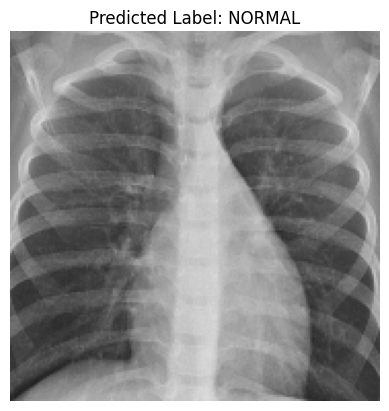

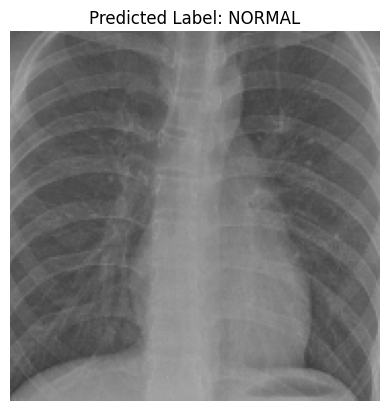

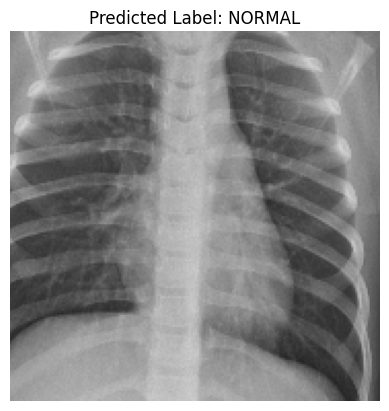

In [ ]:
# Make prediction using the classify_new_images_emd_KNN function
binary_images_emd_vec, binary_images_predicted_label = classify_new_images_emd_KNN(
  binary_model, binary_knn_classifier, binary_knn_images
)

# Iterate over the images
for idx, img in enumerate(binary_knn_images):
    # Plot the image and display the predicted label
    plt.imshow(img)
    plt.title(f"Predicted Label: {binary_labels[binary_images_predicted_label[idx]]}")
    plt.axis('off')
    plt.show()

### Classifying with multiclass model & KNN

In [ ]:
multi_knn_classifier = joblib.load(MULTI_KNN_PATH)

In [ ]:
multi_knn_uploaded_files = files.upload()
multi_knn_images = list(multi_knn_uploaded_files.values())
multi_knn_images = np.array([preprocess_image(img, 0.72) for img in multi_knn_images])

Saving person16_virus_47.jpeg to person16_virus_47 (1).jpeg
Saving person101_bacteria_486.jpeg to person101_bacteria_486.jpeg
Saving person101_bacteria_483.jpeg to person101_bacteria_483.jpeg


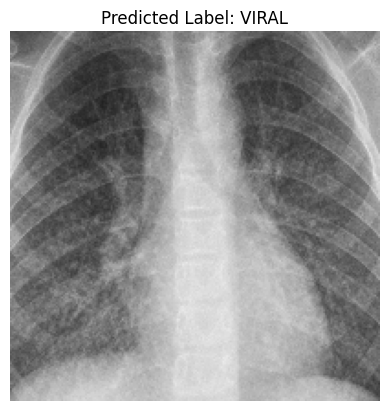

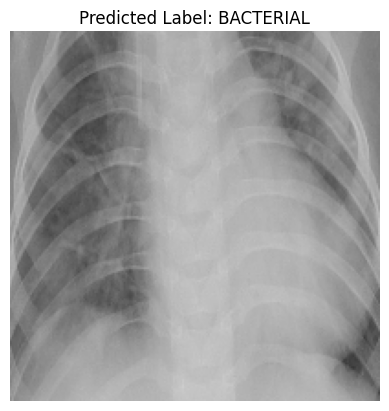

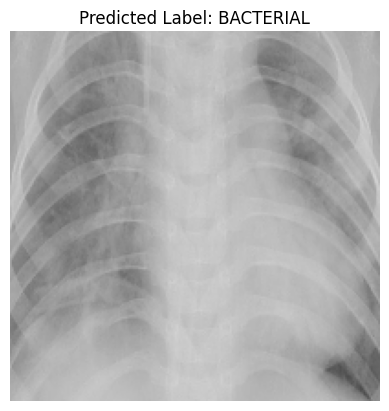

In [ ]:
# Make prediction using the classify_new_images_emd_KNN function
multi_images_emd_vec, multi_images_predicted_label = classify_new_images_emd_KNN(
  multiclass_model, multi_knn_classifier, multi_knn_images
)
# Iterate over the images
for idx, img in enumerate(multi_knn_images):
    # Plot the image and display the predicted label
    plt.imshow(img)
    plt.title(f"Predicted Label: {multiclass_labels[multi_images_predicted_label[idx].argmax()]}")
    plt.axis('off')
    plt.show()

## Classifying via Anomaly Detector

In [ ]:
CNR_IMG_ANOMALY_INPUT_SHAPE=(128, 128, 3)

In [ ]:
def custom_preprocessing(image: tf.Tensor) -> tf.Tensor:
    # Apply central crop with central_fraction = 0.8
    image = tf.image.central_crop(image, central_fraction=0.8)
    # Resize the image to match the target size
    image = tf.image.resize(image, [128, 128])
    return image
def preprocess_uploaded_image(image_bytes):
    img = Image.open(io.BytesIO(image_bytes))
    img = img.resize((128, 128))  # Resize to match the target size
    img = img.convert("RGB")  # Convert to RGB mode
    img = np.array(img) / 255.0  # Rescale pixel values to [0,1]
    img = custom_preprocessing(img)  # Apply the same custom preprocessing
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

In [ ]:
def get_anomaly_detector_model() -> keras.Model:
  model = Sequential()
  model.add(layers.Input(shape=CNR_IMG_ANOMALY_INPUT_SHAPE))
  # Encoder
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2), padding='same'))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2), padding='same'))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2), padding='same'))
  model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2), padding='same'))

  # Decoder
  model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(3, (3, 3), activation='relu', padding='same'))

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
  return model

In [ ]:
anomaly_model = get_anomaly_detector_model()
anomaly_model.load_weights(ANOMALY_MODEL_WEIGHTS_PATH)

> Now you can try our anomaly detector. run the next cell and upload images

In [ ]:
anomaly_uploaded_files = files.upload()

Saving person78_bacteria_381.jpeg to person78_bacteria_381.jpeg
Saving person77_virus_139.jpeg to person77_virus_139.jpeg


> Run this cell in order to see the images reconsturction from the encoder decoder and if the images are anomaly (sick) or normal (healthy)

The image is an anomaly
0.0020833411253988743


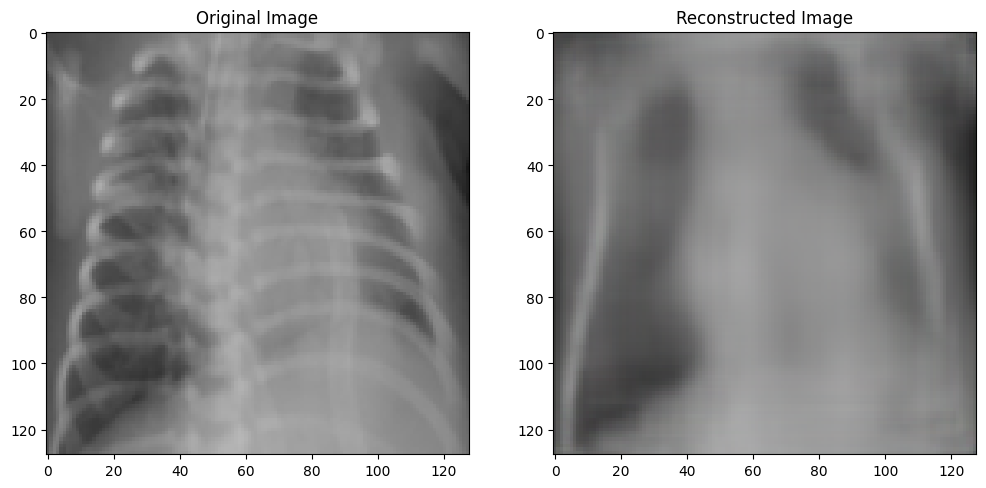

The image is an anomaly
0.002376474905759096


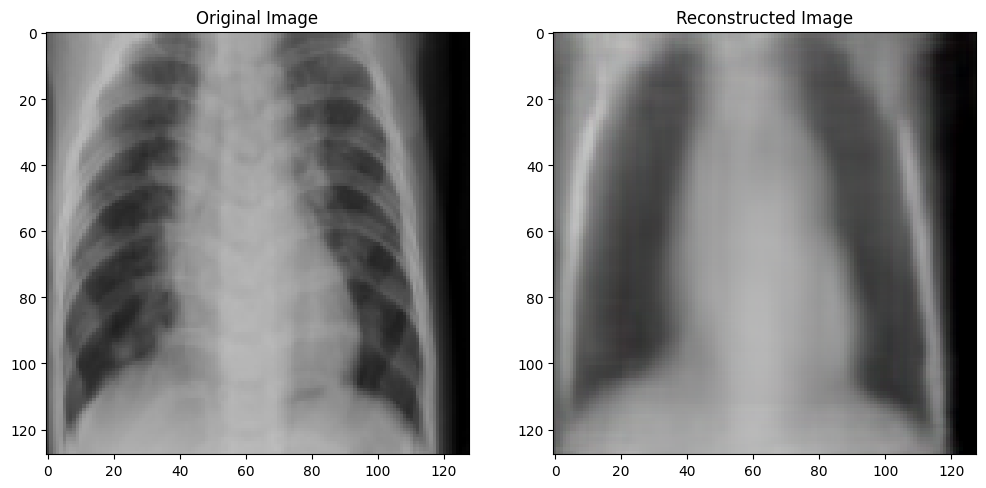

In [ ]:
reconstruction_error_threshold = 0.0035
for filename, image_bytes in anomaly_uploaded_files.items():
    # Preprocess the uploaded image
    uploaded_image = preprocess_uploaded_image(image_bytes)

    # Predict using the trained model
    reconstructed_image = anomaly_model.predict(uploaded_image, verbose=0)
    reconstruction_error = anomaly_model.evaluate(reconstructed_image, uploaded_image, batch_size=1, verbose=0)[0]
    if reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
    else:
        print("The image is NORMAL")
    print(reconstruction_error)
    # Plot the original and reconstructed images
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(uploaded_image[0])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(reconstructed_image[0])
    plt.title("Reconstructed Image")
    plt.show()



# Explainability for the Binary Model
In this section, we present a heatmap that visualizes patches maximizing activation, illustrating the regions within the image that influenced the model's prediction.











In [ ]:
def plot_heatmap(img: np.ndarray) -> np.ndarray:
    base = VGG19(include_top=False, weights="imagenet", input_shape=CNR_IMG_INPUT_SHAPE)
    base.trainable = True

    last_layer_weights = binary_model.layers[-1].get_weights()[0]  # Prediction layer

    # Get weights for the predicted class
    last_layer_weights_for_pred = last_layer_weights[:, :]

    # Get output from the last conv. layer
    last_conv_model = Model(base.input, base.get_layer("block5_conv4").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis, :, :, :], verbose=0)
    last_conv_output = np.squeeze(last_conv_output)

    # Upsample/resize the last conv. output to the same size as the original image
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (img.shape[0] / last_conv_output.shape[0], img.shape[1] / last_conv_output.shape[1], 1), order=1)

    # Calculate heatmap
    heat_map = np.dot(upsampled_last_conv_output.reshape((-1, 512)),
                      last_layer_weights_for_pred).reshape(img.shape[0], img.shape[1])

    # Set heatmap values to 0 where the original image is dark
    heat_map[img[:, :, 0] == 0] = 0

    return heat_map

In [ ]:
def classify_images_heatmap(model: keras.Model,
                    images,
                    central_crop_fraction: float,
                    labels: list[str],
                    threshold: float = 0.5):
  # converting images to numpy arrays
  images = np.array([preprocess_image(img, central_crop_fraction) for img in images])

  # get the probabilities from the model using the images
  probabilities = model.predict(images, verbose=0)

  num_cols = 3
  num_rows = (len(images) + num_cols - 1) // num_cols

  plt.figure(figsize=(3*num_cols, 3*num_rows))
  for idx, img in enumerate(images):
    p = plt.subplot(num_rows, num_cols, idx + 1)
    p.imshow(img)
    heat_map_img = plot_heatmap(img)
    plt.imshow(heat_map_img, cmap='jet', alpha=0.30)
    idx_max_prob = 1 if probabilities[idx, 0] >= threshold else 0
    if len(labels) > 2:
      idx_max_prob = probabilities[idx].argmax()

    p.set_title(f"prediction: {labels[idx_max_prob]}")
    p.axis("off")

  plt.show()

> Here you can upload images and see the heatmap

In [ ]:
binary_heatmap_uploaded_files = files.upload()
binary_heatmap_images = list(binary_heatmap_uploaded_files.values())

Saving IM-0107-0001.jpeg to IM-0107-0001.jpeg
Saving NORMAL2-IM-0012-0001.jpeg to NORMAL2-IM-0012-0001.jpeg
Saving NORMAL2-IM-0023-0001.jpeg to NORMAL2-IM-0023-0001.jpeg
Saving NORMAL2-IM-0027-0001.jpeg to NORMAL2-IM-0027-0001.jpeg


> run this cell to see the heatmap and the prediciton

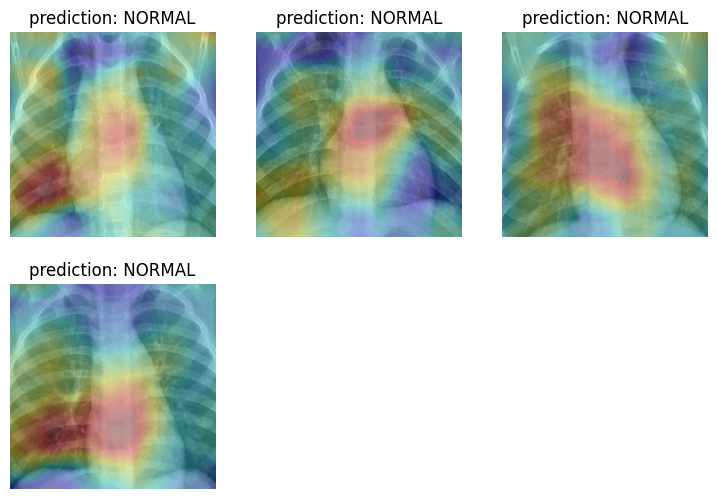

In [ ]:
classify_images_heatmap(binary_model,
                        binary_heatmap_images,
                        central_crop_fraction=0.64,
                        labels=binary_labels)